# Model validation strategy (Windsat Model v2)
Using MODIS IGBP landcover classes and their percentages aggregated into the Windsat Equal degrees grid

In [31]:
#
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable

import sys
import os

sys.path.append("../..")

from src.processing import windsat_datacube, create_landmask, model_preprocess
from src.model import create_training_df


# Files
ws_path = "../../data/raw/daily_windsat/"
igbpMajority_path = "../../data/processed/regridded.h5"
igbpPercentaje_path = "../../data/processed/reprojected_igbp_percent_wsgrid.h5"

### Pixel selection for IGBP classes

For each class "C":  
select all pixels that are class C that also have a percentaje over 70 %  

count the number of selected pixels, discard classes like "water", "urban" and so on


In [32]:
# Load both datasets 
igbp_ds = xr.open_dataset(igbpMajority_path)
igbp_p = xr.open_dataset(igbpPercentaje_path)

# Add the percentaje array and close its file
igbp_ds["IGBP_percent"] = igbp_p.Land_Cover_Type_1_Percent
igbp_p.close()

# Central longitude is 180 deg on a 1/4 deg. grid
igbp_ds = igbp_ds.roll({
    "x" : 180 * 4
})


In [33]:
# Select the layers
igbp = igbp_ds["IGBP"]
igbp_percent = igbp_ds["IGBP_percent"]

# create the new layer with nan values
valid_pixels = np.full(igbp_ds.IGBP.shape,np.nan)

# Threshold is 70% of the pixel
threshold = 70

# Create a mask for each class, set the value of the array to the class
for i in range(igbp_percent.shape[0]):
    mask = igbp_percent[i,:,:] > threshold
    valid_pixels[mask] = i

    
# Cast the array into a new dataArray
valid_pixels_darr = xr.DataArray(valid_pixels, dims=['y', 'x'], coords={'y': igbp_ds.y, 'x': igbp_ds.x}, name='IGBP_threshold')

# Add it to the original Dataset
igbp_ds["IGBP_threshold"] = valid_pixels_darr


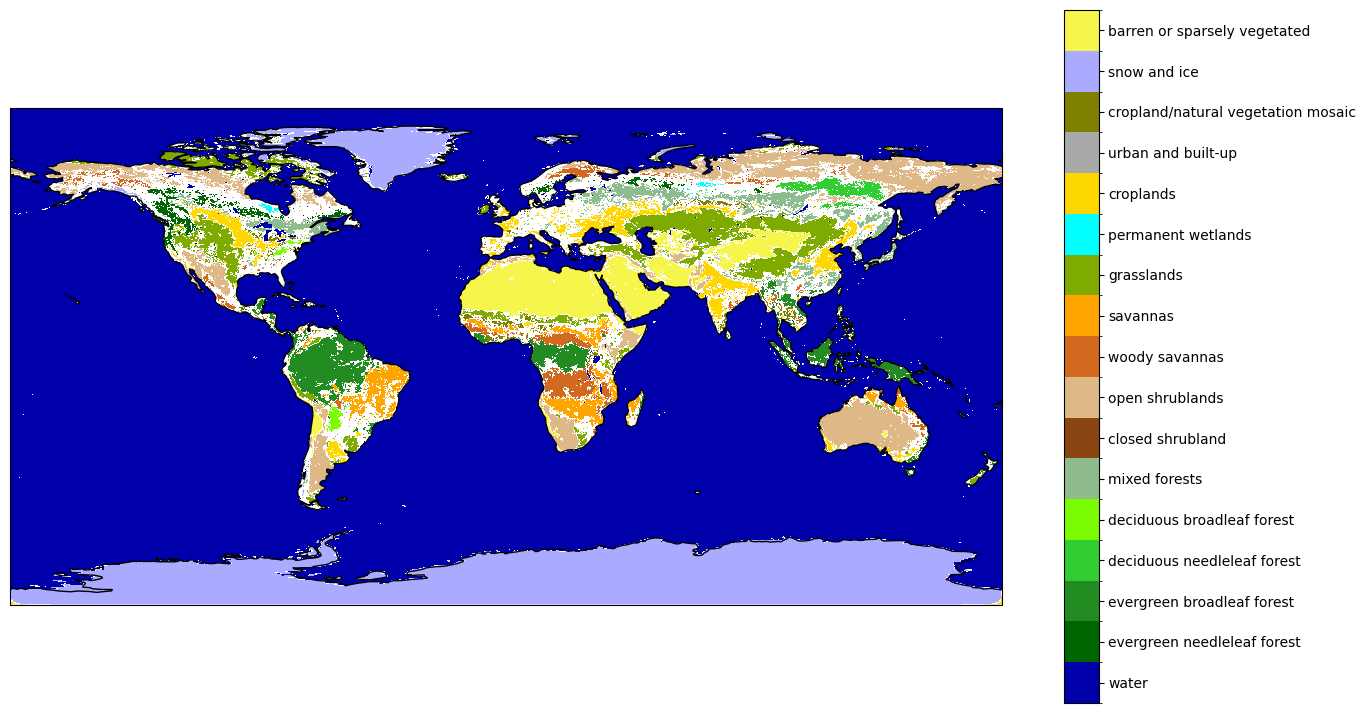

In [34]:
# custom Cmap 
custon_cmap = {
    'water': '#0000AA',
    'evergreen needleleaf forest': '#006400',
    'evergreen broadleaf forest': '#228B22',
    'deciduous needleleaf forest': '#32CD32',
    'deciduous broadleaf forest': '#7CFC00',
    'mixed forests': '#8FBC8F',
    'closed shrubland': '#8B4513',
    'open shrublands': '#DEB887',
    'woody savannas': '#D2691E',
    'savannas': '#FFA500',
    'grasslands': '#7FAA00',
    'permanent wetlands': '#00FFFF',
    'croplands': '#FFD700',
    'urban and built-up': '#A9A9A9',
    'cropland/natural vegetation mosaic': '#808000',
    'snow and ice': '#AAAAFF',
    'barren or sparsely vegetated': '#f5f54c', # changed, too close to white (nans)
}
cmap = mcolors.ListedColormap(list(custon_cmap.values()), name='land_cover')

fig, ax = plt.subplots(1,1,figsize = (16,9), subplot_kw={"projection": ccrs.PlateCarree(central_longitude=0)})
ax.coastlines("110m")


# Create a normalization object
norm = mcolors.BoundaryNorm(np.arange(len(custon_cmap) + 1) - 0.5, len(custon_cmap))

# Create colorbar with custom ticks and labels
cbar = plt.colorbar(ScalarMappable(norm=norm, cmap=cmap), ax=ax, orientation='vertical', pad=0.05)
cbar.set_ticks(np.arange(len(custon_cmap)))
cbar.set_ticklabels(list(custon_cmap.keys()))

# Plot the map
igbp_ds.IGBP_threshold.plot(ax = ax, add_colorbar=False, cmap = cmap)

# Show the plot
plt.show()

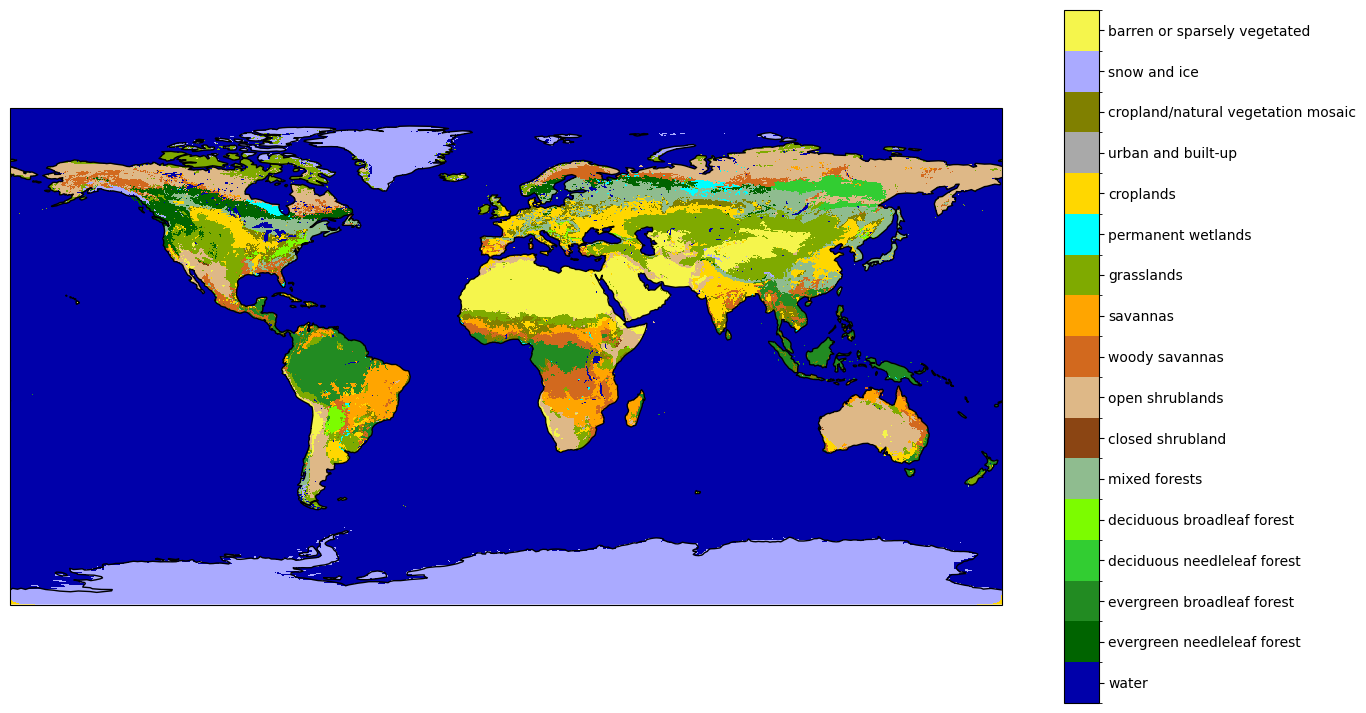

In [35]:
# Comparison with the mayotiry map:
fig, ax = plt.subplots(1,1,figsize = (16,9), subplot_kw={"projection": ccrs.PlateCarree(central_longitude=0)})
ax.coastlines("110m")


# Create a normalization object
norm = mcolors.BoundaryNorm(np.arange(len(custon_cmap) + 1) - 0.5, len(custon_cmap))

# Create colorbar with custom ticks and labels
cbar = plt.colorbar(ScalarMappable(norm=norm, cmap=cmap), ax=ax, orientation='vertical', pad=0.05)
cbar.set_ticks(np.arange(len(custon_cmap)))
cbar.set_ticklabels(list(custon_cmap.keys()))

igbp_ds.IGBP.plot(ax = ax, add_colorbar=False, cmap = cmap)


### Get the number of pixels of each class


In [36]:

# iterate over the classes:
class_count ={i:0 for i in igbp_ds["Num_IGBP_Classes:MOD12C1"].values }
for i in class_count.keys():

    num_pixels = igbp_ds.IGBP_threshold.where(igbp_ds.IGBP_threshold == i).count(dim=["x","y"])
    class_count[i] = int(num_pixels.values)


# Translate id to class name:
name2id = {
 'water': 0,
 'evergreen needleleaf forest': 1,
 'evergreen broadleaf forest': 2,
 'deciduous needleleaf forest': 3,
 'deciduous broadleaf forest': 4,
 'mixed forests': 5,
 'closed shrubland': 6,
 'open shrublands': 7,
 'woody savannas': 8,
 'savannas': 9,
 'grasslands': 10,
 'permanent wetlands': 11,
 'croplands': 12,
 'urban and built-up': 13,
 'cropland/natural vegetation mosaic': 14,
 'snow and ice': 15,
 'barren or sparsely vegetated': 16,
 }
id2name = {v:k for k,v in name2id.items()}

# Create a dataframe to show results
dataframe_dict = {k:v for k,v in zip(name2id.keys(),class_count.values())}

df = pd.DataFrame.from_dict(dataframe_dict, orient="index").reset_index()
df.columns = ["IGBP_class",f"Valid_pixel_count: {threshold}%"]
df

,IGBP_class,Valid_pixel_count: 70%
0,water,688697
1,evergreen needleleaf forest,3361
2,evergreen broadleaf forest,14119
3,deciduous needleleaf forest,2569
4,deciduous broadleaf forest,847
5,mixed forests,9830
6,closed shrubland,4
7,open shrublands,33334
8,woody savannas,7081
9,savannas,7835


### Remove some of the classes we dont consider

In [37]:
selected_classes = [
    # 'water',
    'evergreen needleleaf forest',
    'evergreen broadleaf forest',
    'deciduous needleleaf forest',
    'deciduous broadleaf forest',
    'mixed forests',
    'closed shrubland',
    'open shrublands',
    'woody savannas',
    'savannas',
    'grasslands',
    # 'permanent wetlands',
    'croplands',
    # 'urban and built-up',
    'cropland/natural vegetation mosaic',
    # 'snow and ice',
    'barren or sparsely vegetated',
]

# Filter out classes with very low pixel count
count_threshold = 100
selected_classes = [c for c in selected_classes if class_count[name2id[c]] > count_threshold]
selected_classes

['evergreen needleleaf forest',
 'evergreen broadleaf forest',
 'deciduous needleleaf forest',
 'deciduous broadleaf forest',
 'mixed forests',
 'open shrublands',
 'woody savannas',
 'savannas',
 'grasslands',
 'croplands',
 'cropland/natural vegetation mosaic',
 'barren or sparsely vegetated']

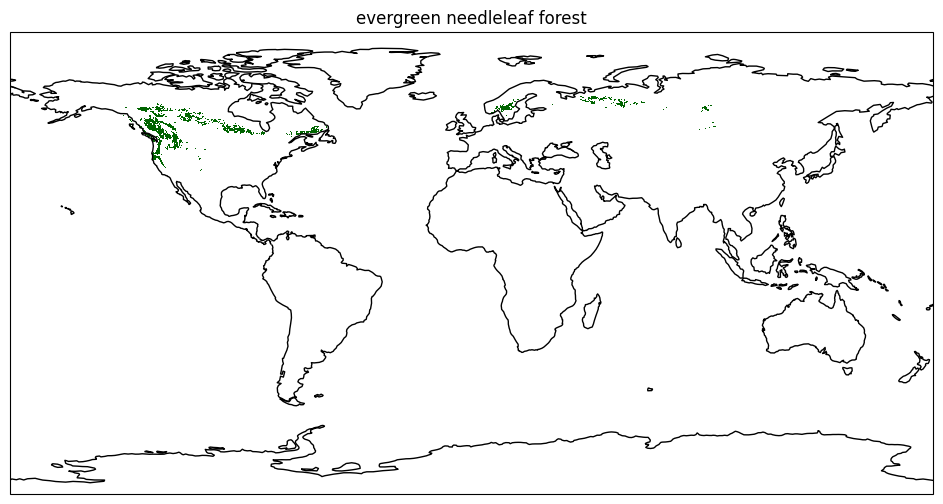

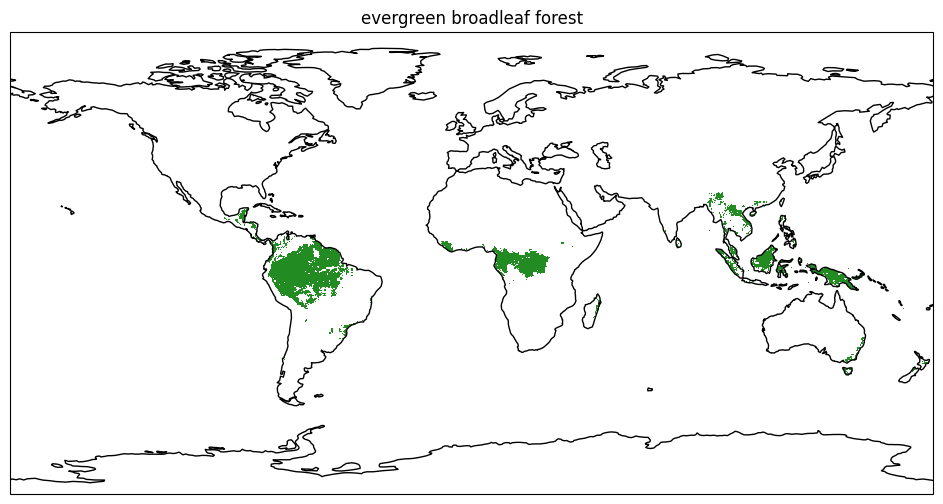

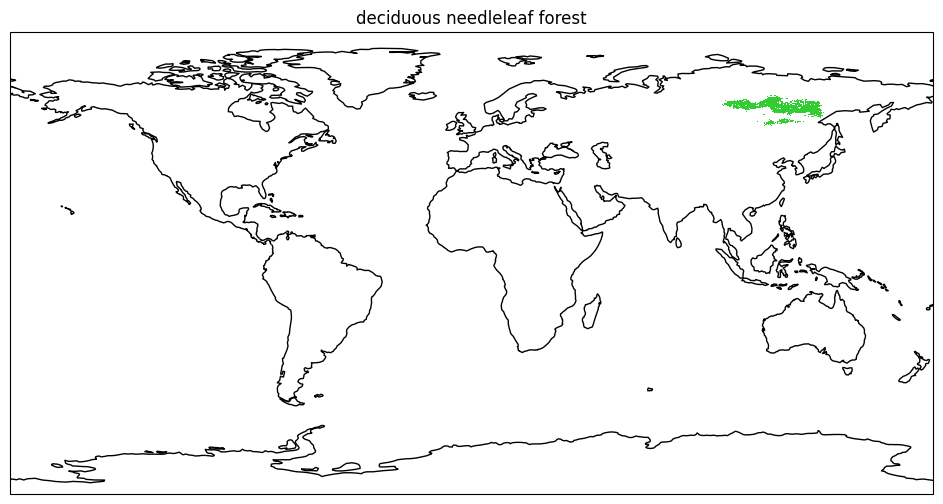

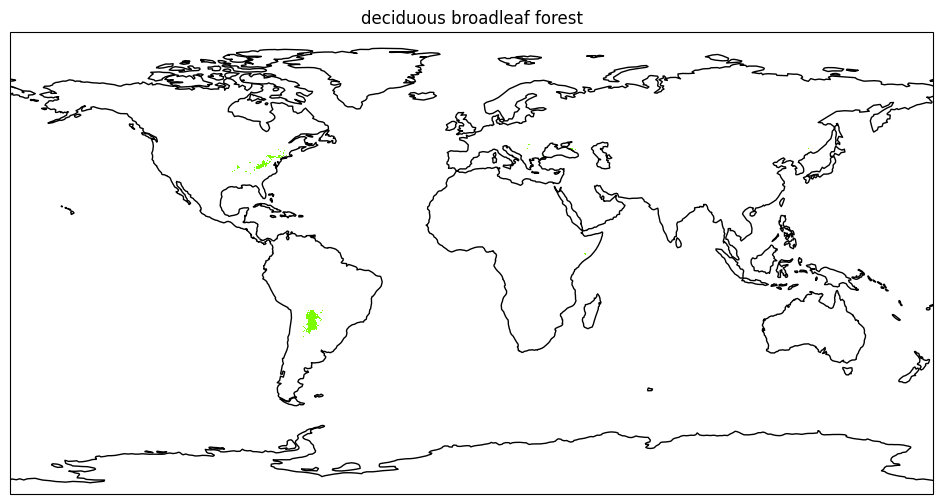

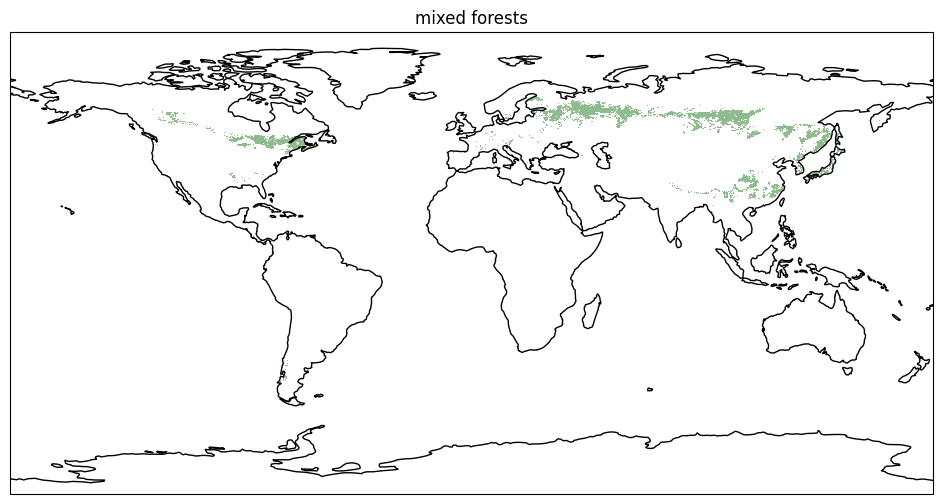

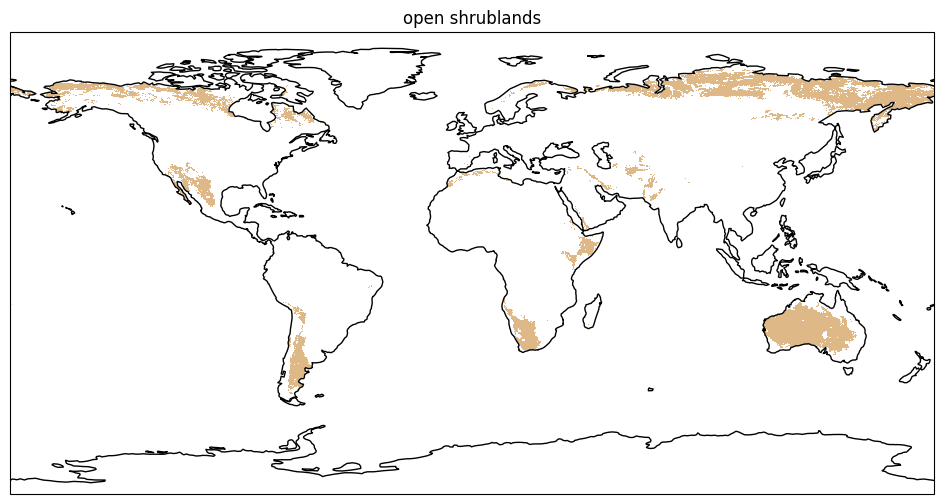

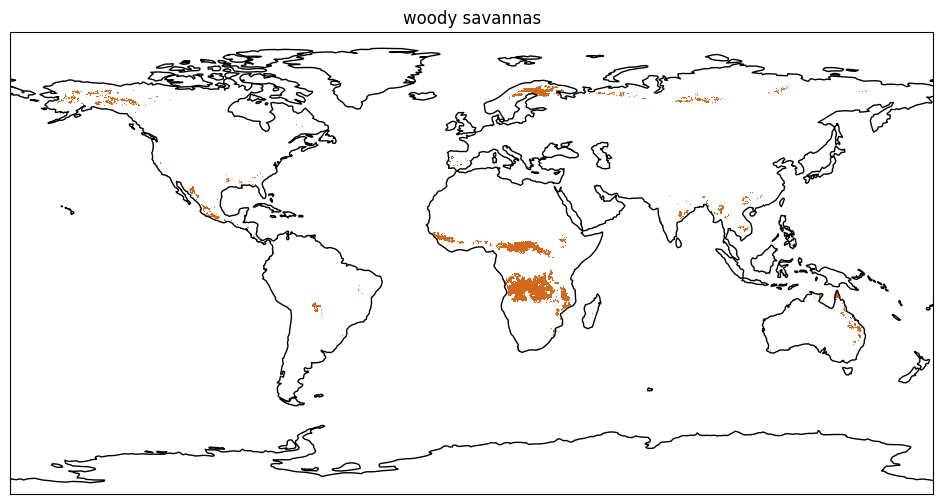

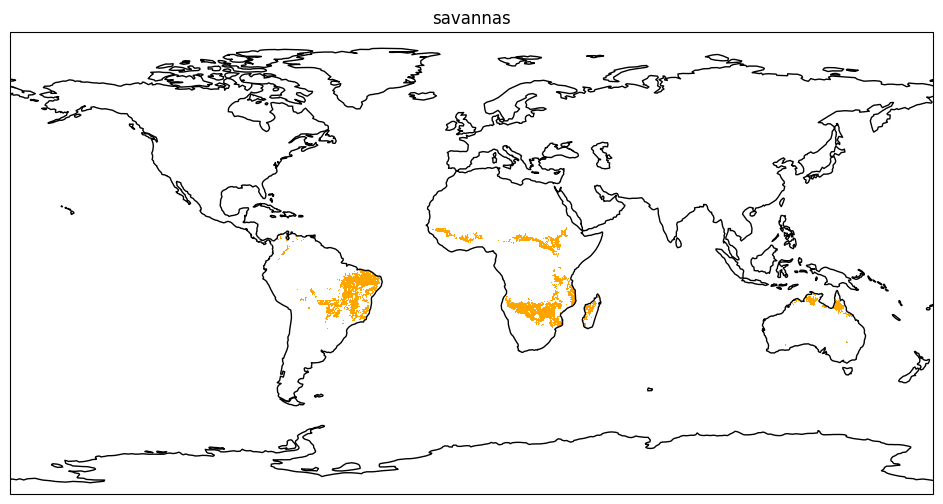

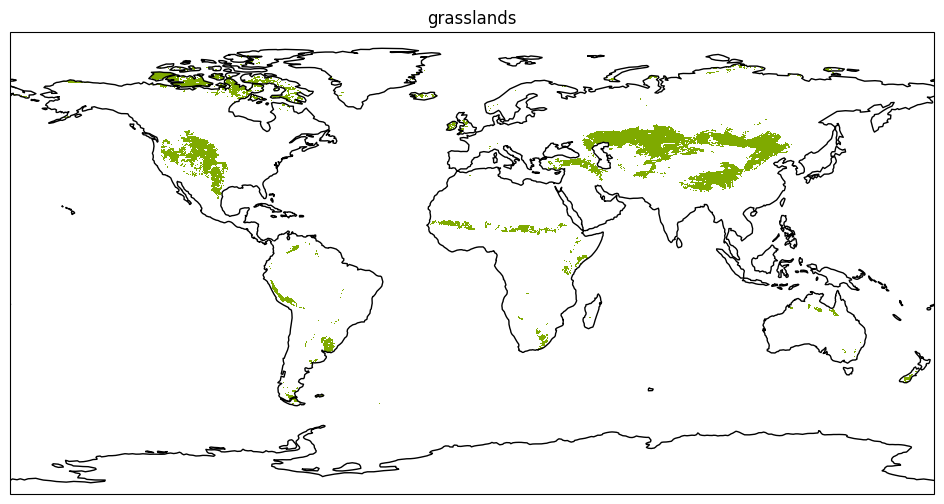

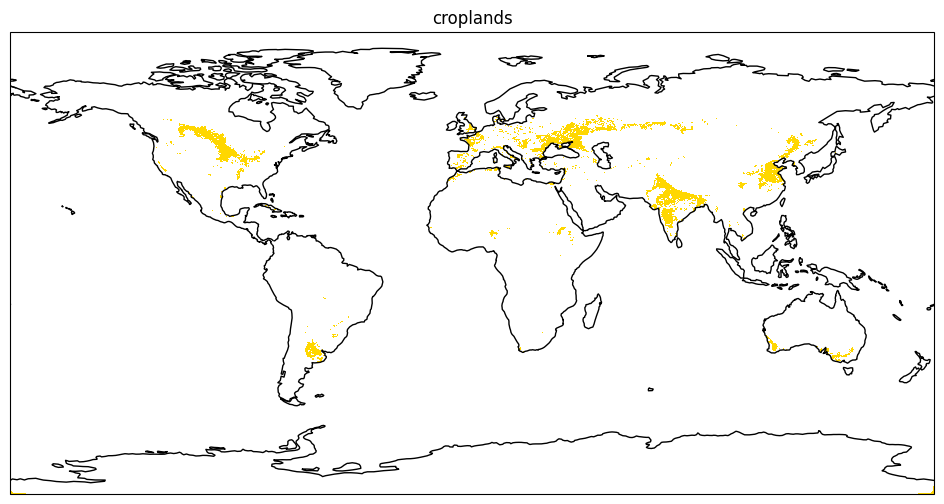

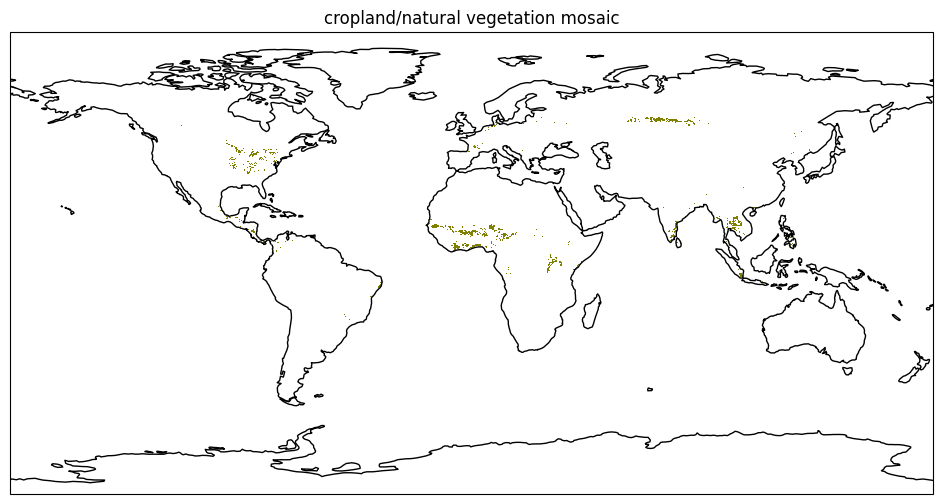

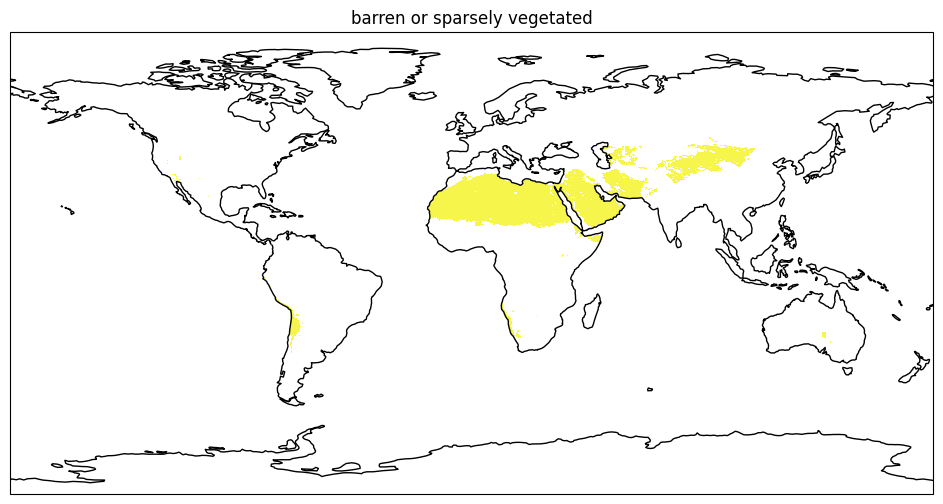

In [38]:
# Plot the maps for all the selected classes:
selected_darr = igbp_ds.IGBP_threshold
for class_name in selected_classes:
    c_id = name2id[class_name]

    class_mask = selected_darr.where(selected_darr == c_id)

    fig, ax = plt.subplots(1,1,figsize = (12,6), subplot_kw={"projection": ccrs.PlateCarree(central_longitude=0)})
    ax.coastlines("110m")

    class_mask.plot(ax = ax, cmap=plt.cm.colors.ListedColormap(['none', custon_cmap[id2name[c_id]]]), add_colorbar = False)

    ax.set_title(f"{class_name}")

# NEXT STEP

Load a model and run it on the test data  

General map and error histogram

Individual validation over each selected IGBP class

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization             │ (None, 10)             │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hiddenLayer1 (Dense)            │ (None, 60)             │           660 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hiddenLayer2 (Dense)            │ (None, 30)             │         1,830 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hiddenLayer3 (Dense)            │ (None, 15)             │           465 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputLayer (Dense)             │ (None, 1)              │            16 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,995 (35.14 KB)

 Trainable params: 2,991 (11.68 KB)

 Non-trainable params: 20 (80.00 B)

 Optimizer params: 5,984 (23.38 KB)

(<Figure size 2400x1000 with 2 Axes>,
 array([<Axes: xlabel='Epoch', ylabel='log(mse [K²])'>,
        <Axes: title={'center': 'Epochs after loss < 10'}, xlabel='Epoch', ylabel='mse [K²]'>],
       dtype=object))

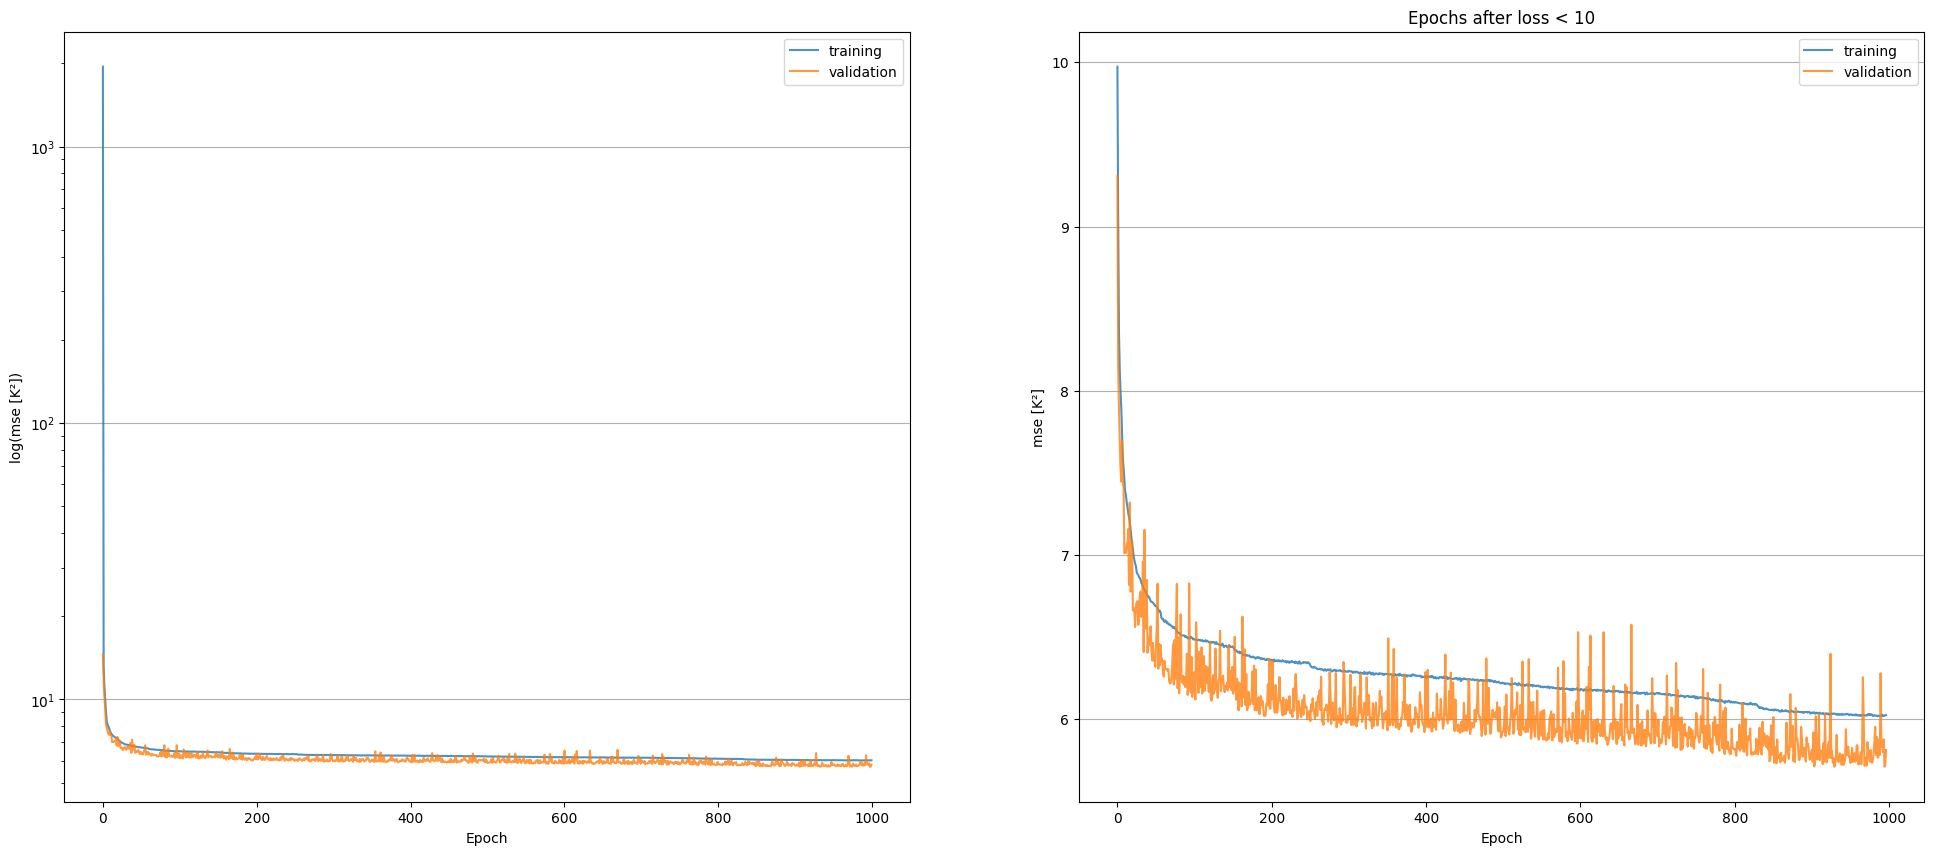

In [39]:
# Load the model
from tensorflow.keras.models import load_model
import pickle
from src.model import plot_history, xy_split
from src.processing import telsem_datacube, doy2month_mapping
from matplotlib.colors import CenteredNorm
from sklearn.metrics import mean_squared_error
from scipy.stats import kstest


model_folder = "../../models"

# Modify this for each model to test:
model_string = "WSMv2_D_2024_07_23T180208" # Latest Descending Model
swath = 1

# model_string = "WSMv2_A_2024_07_23T202640" # Latest ascending Model
# swath = 0
########################################

model_path = os.path.join(model_folder,model_string + ".keras")
history_path = os.path.join(model_folder,model_string + "_history")

# Load and show training history and summary:

model = load_model(model_path)
model.summary()

# Training history
with open(history_path, "rb") as file:
    history = pickle.load(file)

plot_history(history, loss_threshold = 10)

In [40]:
#TELSEM ATLAS
telsem_folder = r"..\..\data\processed\WindsatEmiss"

# Preprocessing of TELSEM atlas:
telsem_ds = telsem_datacube(telsem_folder)
telsem_df = telsem_ds.to_dataframe().dropna().reset_index("month")

In [41]:
# Load windsat data

folder_path = "../../data/raw/daily_Windsat/"
ds = windsat_datacube(folder_path)
swath_ds= model_preprocess(ds, swath_sector=swath, look="impute",add_look_flag=False)
swath_ds = swath_ds.roll({
    "longitude_grid" : 180 * 4
})
# Select the variables from windsat that we need:
d_vars = [
    "surtep_ERA5",
    "lat",
    "lon",
    "tbtoa_18Ghz_V",
    "tbtoa_18Ghz_H",
    "tbtoa_37Ghz_V",
    "tbtoa_37Ghz_H",
]

swath_ds = swath_ds[d_vars]

swath_df = swath_ds.to_dataframe().dropna().reset_index("day_number")

day_mapping = doy2month_mapping()

swath_df["month"] = swath_df["day_number"].apply(lambda x: day_mapping[x])
# drop the day_number column
swath_df = swath_df.drop(columns="day_number")

# Inner join the telsem df and the ascending df
combined_df = pd.merge(left=swath_df, right=telsem_df, how="inner")

# Drop the month column
combined_df = combined_df.drop(columns="month")
combined_df

,surtep_ERA5,lat,lon,tbtoa_18Ghz_V,tbtoa_18Ghz_H,tbtoa_37Ghz_V,tbtoa_37Ghz_H,Emis19V,Emis19H,Emis37V,Emis37H
0,281.670471,-55.875,292.125,198.703393,133.243396,222.274487,172.835399,0.715009,0.504688,0.773820,0.580258
1,281.703644,-55.625,291.875,208.514965,150.382994,232.142393,190.532100,0.774127,0.605450,0.820554,0.666538
2,280.897614,-55.375,290.625,232.017487,196.492493,247.942505,224.702499,0.867672,0.764766,0.899219,0.819995
3,281.388062,-55.375,291.375,235.268195,201.929346,249.889403,226.368030,0.875530,0.783070,0.893727,0.812385
4,281.513428,-55.375,291.625,230.119642,190.062703,244.655528,214.429427,0.871065,0.774710,0.887698,0.799365
...,...,...,...,...,...,...,...,...,...,...,...
1289277,275.467773,70.125,20.875,202.009995,141.417496,210.697495,159.542511,0.665505,0.413298,0.703039,0.440390
1289278,279.481720,70.625,22.125,194.354996,123.147499,206.949997,146.887497,0.669632,0.419112,0.707013,0.448490
1289279,279.285858,70.625,22.375,201.444992,136.897491,209.597504,156.194992,0.670714,0.420704,0.707621,0.449943
1289280,278.693848,70.625,22.625,206.940002,148.145004,211.679993,163.494995,0.671796,0.422296,0.708228,0.451395


In [42]:
# For the majority of models, lat lon are tranformed as folows: 
""" lat = sin(lat), lon = sin(lon)"""

# Save the original lat lon for plotting later
lat = combined_df["lat"].copy()
lon = combined_df["lon"].copy()

combined_df["lon"] = combined_df["lon"].apply(lambda x: np.sin(np.deg2rad(x)))
combined_df["lat"] = combined_df["lat"].apply(lambda x: np.sin(np.deg2rad(x)))

In [43]:
# Predict for the local sample:
X, y = xy_split(combined_df, y_column = "surtep_ERA5")
combined_df["surtep_MODEL"] = model.predict(X)
combined_df["error"] = combined_df["surtep_MODEL"] - combined_df["surtep_ERA5"] 

38205/40291 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

In [ ]:
# Re add lon and lat as they were
combined_df["lat"] = lat
combined_df["lon"] = lon

# Calculate the error per pixel, group by lat and lon
error_df = combined_df[["lat","lon","error"]]
error_df.set_index(keys=["lat","lon"], inplace=True)
error_df = error_df.groupby(by=["lat","lon"]).mean()
error_df.reset_index(inplace=True)
error_df

,lat,lon,error
0,-62.625,298.875,3.264694
1,-62.625,299.125,3.994720
2,-55.875,292.125,-0.611523
3,-55.875,292.375,-1.155123
4,-55.875,292.875,-0.663754
...,...,...,...
234206,83.125,319.125,4.239914
234207,83.125,319.625,2.162827
234208,83.125,319.875,1.454330
234209,83.125,320.125,1.541962


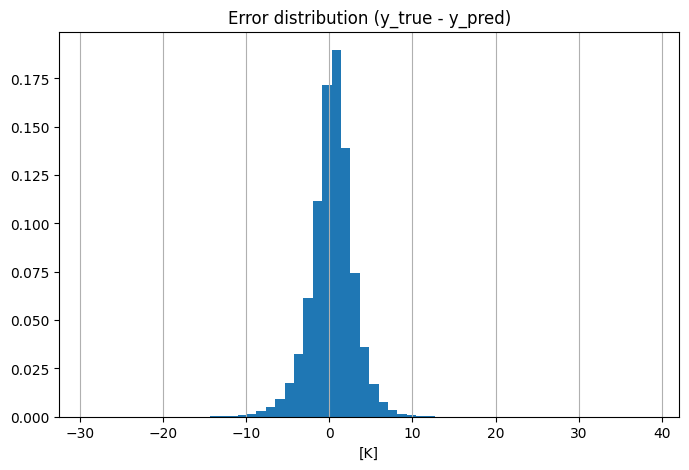

In [ ]:
# Error histogram:
# Do some plotting to check error distribution
fig, ax = plt.subplots(1,1,figsize = (8,5))

ax.hist(x = combined_df["error"],
    density = True, bins = 60
)
ax.grid(axis="x")
ax.set_title("Error distribution (y_true - y_pred)")
ax.set_xlabel("[K]")
plt.show()

# Calculate the rmse
rmse = np.sqrt(mean_squared_error(combined_df["surtep_MODEL"],y))


In [ ]:
from matplotlib.colors import LinearSegmentedColormap
color_min    = "#ff0000"
color_center = "#BBBBBB" 
color_max    = "#0000FF"
error_cmap = LinearSegmentedColormap.from_list(
    "cmap_name",
    [color_min, color_center, color_max]
)

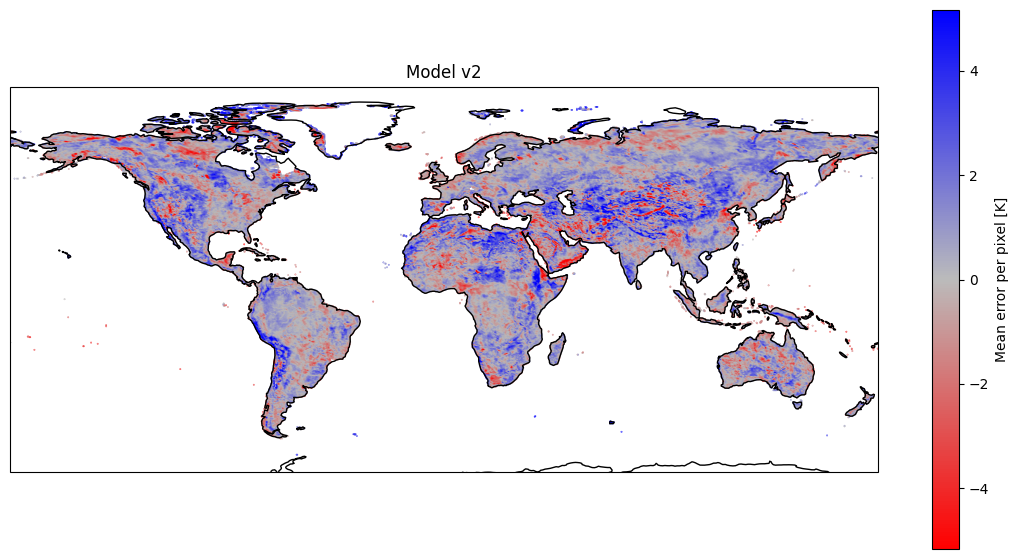

In [ ]:
# MAPS
fig, ax = plt.subplots(1,1,figsize = (14,7), subplot_kw={"projection":ccrs.PlateCarree()} )

ax.coastlines("110m")

norm = CenteredNorm(vcenter=0,halfrange=2*rmse, clip = False)

scatter = ax.scatter(
    x = error_df["lon"],
    y = error_df["lat"],
    s= 0.1,
    alpha = 1,
    c = error_df["error"],
    cmap = error_cmap,
    norm=norm
)

ax.set_title("Model v2")

fig.colorbar(scatter, ax=ax, orientation='vertical', label='Mean error per pixel [K]')

plt.show()


---
## Now, select the pixels in a class and do this all over again

In [ ]:
i = 1

class_name = selected_classes[i]
class_id = name2id[class_name]

class_mask = igbp_ds.IGBP_threshold == class_id

# Align longitude to the swath dataset
class_mask = class_mask.roll({
    "x" : 180 * 4
})

# Add class mask to the swath dataframe
swath_ds["IGBP_mask"] = (("latitude_grid","longitude_grid"), class_mask.values)

# Select the swath
swath_selection = swath_ds.where(swath_ds.IGBP_mask == True)

# Drop the IGBP_mask dvar
swath_selection = swath_selection.drop_vars("IGBP_mask")


In [ ]:
# Same as before with the new selection
swath_df = swath_selection.to_dataframe().dropna().reset_index("day_number")

swath_df["month"] = swath_df["day_number"].apply(lambda x: day_mapping[x])
# drop the day_number column
swath_df = swath_df.drop(columns="day_number")

# Inner join the telsem df and the ascending df
combined_df = pd.merge(left=swath_df, right=telsem_df, how="inner")

# Drop the month column
combined_df = combined_df.drop(columns="month")
combined_df

,surtep_ERA5,lat,lon,tbtoa_18Ghz_V,tbtoa_18Ghz_H,tbtoa_37Ghz_V,tbtoa_37Ghz_H,Emis19V,Emis19H,Emis37V,Emis37H
0,296.345581,-34.875,296.625,266.749704,240.392336,269.933418,248.993103,0.933383,0.903973,0.920064,0.893917
1,295.802612,-34.875,296.875,264.640194,234.626832,267.898514,243.725999,0.934334,0.905461,0.921100,0.895848
2,295.947784,-34.875,297.125,261.809998,229.057495,265.390015,239.684998,0.932833,0.901906,0.920288,0.892826
3,298.344604,-34.625,296.125,269.092499,244.114437,271.336870,251.101457,0.940470,0.910612,0.926685,0.901453
4,297.291321,-34.625,296.375,264.492855,236.405458,267.276938,244.134633,0.938207,0.906709,0.924266,0.896059
...,...,...,...,...,...,...,...,...,...,...,...
35910,293.553619,19.375,109.875,276.862488,272.667480,276.872498,273.429993,0.897629,0.844676,0.904213,0.871706
35911,289.293152,20.375,105.125,275.234333,272.419825,275.821071,272.613579,0.937555,0.919492,0.922895,0.904855
35912,289.643555,20.375,105.375,274.035925,269.836850,275.110704,270.941463,0.929787,0.902152,0.920005,0.895979
35913,300.518250,21.125,286.875,227.064790,173.057401,238.198777,193.163339,0.603152,0.337489,0.637757,0.374364


In [ ]:
# Save the original lat lon for plotting later
lat = combined_df["lat"].copy()
lon = combined_df["lon"].copy()

combined_df["lon"] = combined_df["lon"].apply(lambda x: np.sin(np.deg2rad(x)))
combined_df["lat"] = combined_df["lat"].apply(lambda x: np.sin(np.deg2rad(x)))

# Predict for the local sample:
X, y = xy_split(combined_df, y_column = "surtep_ERA5")
combined_df["surtep_MODEL"] = model.predict(X)
combined_df["error"] = combined_df["surtep_MODEL"] - combined_df["surtep_ERA5"] 

1123/1123 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [ ]:
# Re add lon and lat as they were
combined_df["lat"] = lat
combined_df["lon"] = lon

# Calculate the error per pixel, group by lat and lon
error_df = combined_df[["lat","lon","error"]]
error_df.set_index(keys=["lat","lon"], inplace=True)
error_df = error_df.groupby(by=["lat","lon"]).mean()
error_df.reset_index(inplace=True)
error_df

,lat,lon,error
0,-34.875,296.625,0.469975
1,-34.875,296.875,1.245880
2,-34.875,297.125,1.085941
3,-34.625,296.125,-0.788099
4,-34.625,296.375,-0.481598
...,...,...,...
3892,26.625,277.875,-3.636190
3893,27.125,277.625,-2.703756
3894,27.125,277.875,-1.886709
3895,27.375,277.625,-2.700032


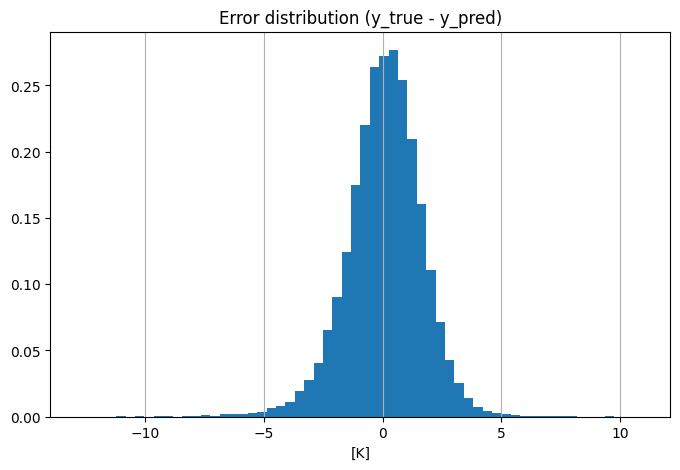

In [ ]:
# Error histogram:
# Do some plotting to check error distribution
fig, ax = plt.subplots(1,1,figsize = (8,5))

ax.hist(x = combined_df["error"],
    density = True, bins = 60
)
ax.grid(axis="x")
ax.set_title("Error distribution (y_true - y_pred)")
ax.set_xlabel("[K]")
plt.show()


In [ ]:
# Other Statistics
n_obs = len(combined_df)

rmse = np.sqrt(mean_squared_error(combined_df["surtep_MODEL"],y))

bias = combined_df["error"].mean()

# Kolmogorov-Smirnov (for a normal distribution)
mean_error = combined_df["error"].mean()
std_error = combined_df["error"].std()

ks_stat, ks_p = kstest(combined_df["error"], 'norm', args=(mean_error, std_error))

# save all statins into a dataframe row
result_df = pd.DataFrame({
    'class_name': [class_name],
    'class_bias [K]': [mean_error],
    'std [K]': [std_error],
    'rmse [K]': [rmse],
    'ks_stat': [ks_stat],
    'p-value': [ks_p],
    'n_obs' : [n_obs]
})

result_df


,class_name,class_bias [K],std [K],rmse [K],ks_stat,p-value,n_obs
0,evergreen broadleaf forest,0.078803,1.599976,1.601893,0.033106,1.237324e-34,35915


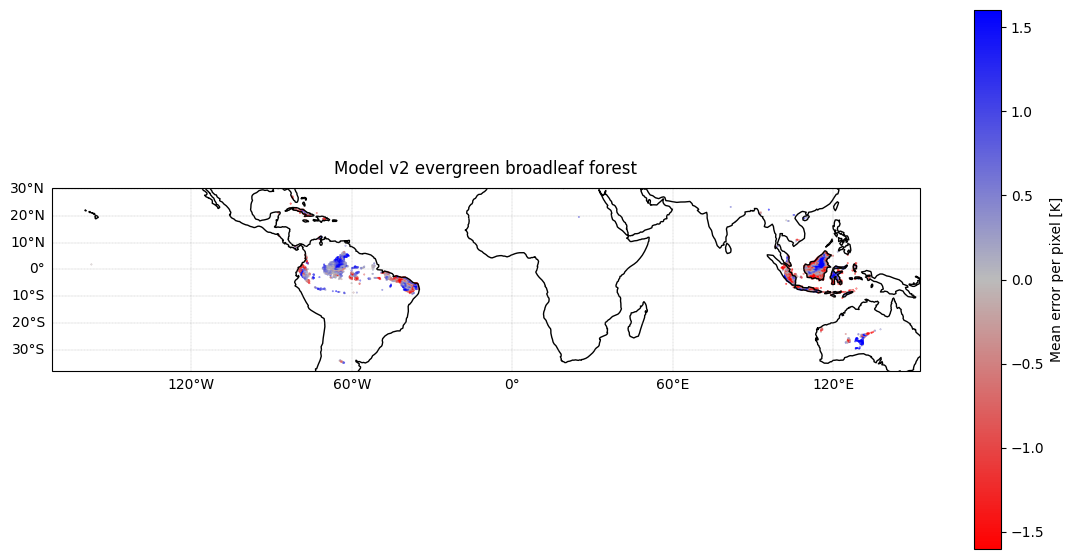

In [ ]:
# MAPS
fig, ax = plt.subplots(1,1,figsize = (14,7), subplot_kw={"projection":ccrs.PlateCarree()} )

ax.coastlines("110m")

norm = CenteredNorm(vcenter=0,halfrange=rmse, clip = False)

scatter = ax.scatter(
    x = error_df["lon"],
    y = error_df["lat"],
    s= 0.1,
    alpha = 1,
    c = error_df["error"],
    cmap = error_cmap,
    norm=norm
)

ax.set_title(f"Model v2 {class_name}")

fig.colorbar(scatter, ax=ax, orientation='vertical', label='Mean error per pixel [K]')

# Add gridlines and labels
gl = ax.gridlines(draw_labels=True, linewidth=0.2, color='gray', alpha=0.9, linestyle='--')
gl.top_labels = False
gl.right_labels = False

# Display the plot
plt.show()


## House all of this into a nice function

In [ ]:
def get_statistics(class_name: str, plot_maps: bool = False) -> tuple[pd.DataFrame, np.ndarray]:
    class_id = name2id[class_name]
    class_mask = igbp_ds.IGBP_threshold == class_id

    # Align longitude to the swath dataset
    class_mask = class_mask.roll({"x": 180 * 4})

    # Add class mask to the swath dataframe
    swath_ds["IGBP_mask"] = (("latitude_grid", "longitude_grid"), class_mask.values)

    # Select the swath
    swath_selection = swath_ds.where(swath_ds.IGBP_mask == True)

    # Drop the IGBP_mask dvar
    swath_selection = swath_selection.drop_vars("IGBP_mask")

    # Same as before with the new selection
    swath_df = swath_selection.to_dataframe().dropna().reset_index("day_number")

    swath_df["month"] = swath_df["day_number"].apply(lambda x: day_mapping[x])
    # drop the day_number column
    swath_df = swath_df.drop(columns="day_number")

    # Inner join the telsem df and the ascending df
    combined_df = pd.merge(left=swath_df, right=telsem_df, how="inner")

    # Drop the month column
    combined_df = combined_df.drop(columns="month")

    # Save the original lat lon for plotting later
    lat = combined_df["lat"].copy()
    lon = combined_df["lon"].copy()

    combined_df["lon"] = combined_df["lon"].apply(lambda x: np.sin(np.deg2rad(x)))
    combined_df["lat"] = combined_df["lat"].apply(lambda x: np.sin(np.deg2rad(x)))

    # Predict for the local sample:
    X, y = xy_split(combined_df, y_column="surtep_ERA5")
    combined_df["surtep_MODEL"] = model.predict(X)
    combined_df["error"] = combined_df["surtep_MODEL"] - combined_df["surtep_ERA5"] 

    # Re add lon and lat as they were
    combined_df["lat"] = lat
    combined_df["lon"] = lon

    # Calculate the error per pixel, group by lat and lon
    error_df = combined_df[["lat","lon","error"]]
    error_df.set_index(keys=["lat","lon"], inplace=True)
    error_df = error_df.groupby(by=["lat","lon"]).mean()
    error_df.reset_index(inplace=True)

    # Statistics
    n_obs = len(combined_df)

    rmse = np.sqrt(mean_squared_error(combined_df["surtep_MODEL"], y))

    bias = combined_df["error"].mean()

    # Kolmogorov-Smirnov (for a normal distribution)
    mean_error = combined_df["error"].mean()
    std_error = combined_df["error"].std()

    ks_stat, ks_p = kstest(combined_df["error"], 'norm', args=(mean_error, std_error))

    # save all statins into a dataframe row
    result_df = pd.DataFrame({
        'class_name': [class_name],
        'bias [K]': [bias],
        'std [K]': [std_error],
        'rmse [K]': [rmse],
        'ks_stat': [ks_stat],
        'p-value': [ks_p],
        'n_obs': [n_obs]
    })

    if plot_maps:

        fig, ax = plt.subplots(1, 1, figsize=(14, 7), subplot_kw={"projection": ccrs.PlateCarree()})

        ax.coastlines("10m")
        ax.set_title(f"{class_name}")

        norm = CenteredNorm(vcenter=0, halfrange=2 * rmse + abs(bias), clip=False)

        scatter = ax.scatter(
            x = error_df["lon"],
            y = error_df["lat"],
            s= 0.1,
            alpha = 1,
            c = error_df["error"],
            cmap = error_cmap,
            norm=norm
        )

        ax.set_title(f"Model v2 {class_name}")

        fig.colorbar(scatter, ax=ax, orientation='vertical', label='Mean error per pixel [K]')

        # Add gridlines and labels
        gl = ax.gridlines(draw_labels=True, linewidth=0.2, color='gray', alpha=0.9, linestyle='--')
        gl.top_labels = False
        gl.right_labels = False

        # Display the plot
        plt.show()

    return result_df, combined_df["error"].values


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Inicializar DataFrame para resultados y lista para errores
results_df = pd.DataFrame()
all_errors = []

for class_name in selected_classes:
    # Wrapper
    class_df, error_data = get_statistics(class_name, plot_maps=False)
    results_df = pd.concat([class_df, results_df], ignore_index=True)

    # Append errors with class labels
    error_df = pd.DataFrame({'class_name': class_name, 'error': error_data})
    all_errors.append(error_df)

# Concatenate all error DataFrames
all_errors_df = pd.concat(all_errors, ignore_index=True)


618/618 ━━━━━━━━━━━━━━━━━━━━ 1s 813us/step
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 1s 839us/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step
892/892 ━━━━━━━━━━━━━━━━━━━━ 1s 788us/step
3192/3192 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
425/425 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step
2673/2673 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 1s 839us/step
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 606us/step
835/835 ━━━━━━━━━━━━━━━━━━━━ 1s 724us/step


In [ ]:
results_df

,class_name,bias [K],std [K],rmse [K],ks_stat,p-value,n_obs
0,barren or sparsely vegetated,0.461485,2.611128,2.651547,0.034105,2.028742e-27,26702
1,cropland/natural vegetation mosaic,0.635398,3.195312,3.257512,0.058478,2.911428e-13,4313
2,croplands,0.303120,3.018879,3.034013,0.047456,2.869863e-65,33126
3,grasslands,0.451678,2.778342,2.814801,0.043923,7.932981e-144,85532
4,savannas,-0.139674,2.450639,2.454535,0.045517,2.581635e-27,14928
5,woody savannas,0.209307,2.291434,2.300889,0.065187,1.376671e-50,13573
6,open shrublands,0.140294,2.544592,2.548444,0.047212,3.039420e-198,102118
7,mixed forests,0.581152,2.687603,2.749672,0.056319,3.989174e-79,28540
8,deciduous broadleaf forest,-0.277435,3.533930,3.544538,0.038533,5.111631e-09,6652
9,deciduous needleleaf forest,0.467937,2.542008,2.582474,0.026587,8.157804e-01,557


In [ ]:
swath

In [ ]:
# Create a copy and rename class_name to "All Classes", extend the full dataframe and plot

all_classes_errors_df = all_errors_df.copy()

all_classes_errors_df["class_name"] = ["All Classes" for _ in range(len(all_classes_errors_df))]

all_errors_df = pd.concat([all_errors_df, all_classes_errors_df])
all_errors_df.groupby("class_name").count()

,error
class_name,
All Classes,371717
barren or sparsely vegetated,26702
cropland/natural vegetation mosaic,4313
croplands,33126
deciduous broadleaf forest,6652
deciduous needleleaf forest,557
evergreen broadleaf forest,35915
evergreen needleleaf forest,19761
grasslands,85532


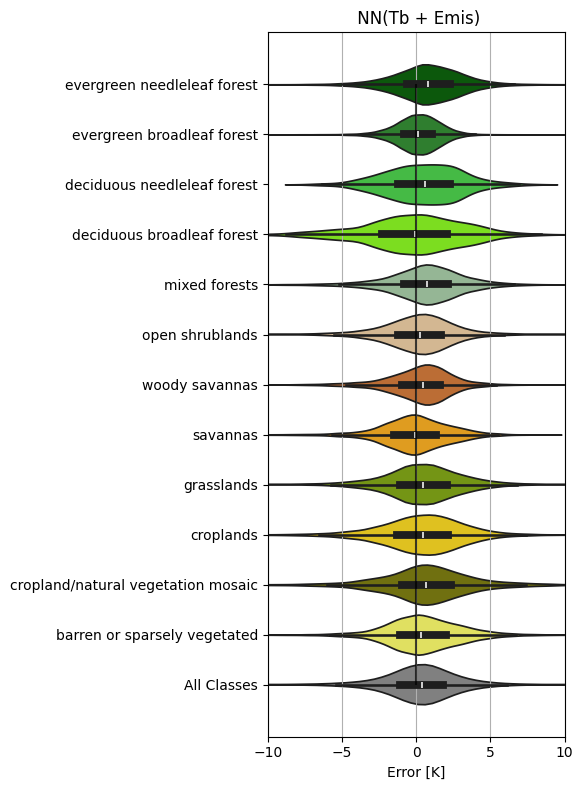

In [ ]:
# Filter the colormap
filtered_cmap = {class_name: custon_cmap[class_name] for class_name in selected_classes if class_name in custon_cmap}
filtered_cmap["All Classes"] = "Gray"

# Generate the violin plot
plt.figure(figsize=(6, 8))
sns.violinplot(y="class_name", x='error', data=all_errors_df, hue="class_name", palette=filtered_cmap, inner='box', density_norm='width', legend=False)
plt.ylabel('')
plt.xlabel('Error [K]')
plt.title(' NN(Tb + Emis)')
plt.yticks(rotation=0)
plt.grid(axis="x")

plt.vlines(x = 0, ymin ="All Classes", ymax = "evergreen needleleaf forest", colors= "Black" , alpha = 0.7)

plt.xlim([-10,10])
plt.tight_layout()
plt.show()


In [ ]:
swath

0